In [1]:
!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [3]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


11490434/11490434 [==============================] - 2s 0us/step


# Spiking neural net

In [45]:
class Brain():
    def __init__(self, n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10,
                 low=-1, resting=0, threshold=1, peak=5, decay=0.5, seed=2020):
        """ Create a brain with hidden, input, and output neurons
            Args:
            - n_neurons [int]: total number of neurons
            - n_inputs [int]: number of neurons having input
            - n_outputs [int]: number of neurons having output
            - n_connections [int]: number of connections per neuron
            - low: minimum potential of neuron
            - resting: resting potential of neuron
            - threshold: threshold potential of neuron
            - peak: peak fire potential (action potential) of neuron
            - decay [float]: decay rate of neuron potential
            - seed [int]: random seed for numpy
            Return: Brain object
        """
        assert n_neurons >= n_outputs + n_inputs
        assert n_neurons >= n_connections
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_connections = n_connections
        self.low = low
        self.resting = resting
        self.threshold = threshold
        self.peak = peak
        self.decay = decay
        np.random.seed(seed)
        self.mask = self.generate_mask()
        self.initialize_weights()
        self.initialize_neurons()

    def generate_mask(self):
        """ Determine how the neurons are connected. It will try to generate on average n_connections per neurons.
            No self-connection are allowed.
        """
        threshold = (self.n_connections + 1) / self.n_neurons
        return (np.random.rand(self.n_neurons, self.n_neurons) < threshold) & ~np.identity(self.n_neurons, dtype='bool')

    def initialize_weights(self, seed=None):
        """ Initialize the weights of conected neurons to be between -1 and 1. """
        if seed:
            np.random.seed(seed)
        self.weights = (2 * np.random.rand(self.n_neurons, self.n_neurons).astype('float32') - 1) * self.mask

    def initialize_neurons(self):
        self.neurons = np.ones(self.n_neurons).astype('float32') * self.resting  # potentials of the neurons
        self.neurons_fire = np.zeros(self.n_neurons, dtype='bool')               # whether the neurons fires or not

    def forward_pass(self):
        # compute input potential
        neurons_next = np.dot(self.weights, self.neurons_fire * self.peak) + self.decay * self.neurons
        # If the neuron has just fired, then suppress its potential to the lowest potential
        neurons_next = np.where(self.neurons_fire, self.low, neurons_next)
        neurons_next = np.clip(neurons_next, a_min=self.low, a_max=None)
        # If input potential (x) is greater than threshold, then fire at peak potential, otherwise no change.
        self.neurons = neurons_next
        self.neurons_fire = self.neurons >= self.threshold

    def train_hebbian_one_step(self, learning_rate=0.05):
        """ Train with Hebbian like method (unsupervised learning)
            dW_ij = lr * (next_fire_i * M_ij * prev_fire_j - prev_fire_i * M_ij * next_fire_j)
                  = lr * M_ij * (next_fire_i * prev_fire_j - prev_fire_i * next_fire_j)
        """
        prev_fire = self.neurons_fire
        self.forward_pass()
        next_fire = self.neurons_fire
        # dW = learning_rate * next_fire.reshape(-1, 1) * self.weights * next_fire
        dW = learning_rate * self.mask * (
            next_fire.reshape(-1, 1) * prev_fire - 1 * prev_fire.reshape(-1, 1) * next_fire
        )
        self.weights = np.clip(self.weights + dW, a_min=-1, a_max=1)

    def set_inputs(self, inputs):
        self.neurons[:self.n_inputs] = inputs / self.decay

    def get_outputs(self):
        return self.neurons[self.n_inputs : self.n_inputs + self.n_outputs]

    def predict(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
        return self.get_outputs()

    def predict_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_outputs), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.get_outputs()
        return hist

    def predict_brain_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.neurons
        return hist

    def train_hebbian_brain_history(self, inputs, steps=10, lr=0.05, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.train_hebbian_one_step(lr)
            hist[step] = self.neurons
        return hist

    def train_hebbian_brain_batch(self, X, total_steps=1000, steps_per_sample=10, lr=0.05, constant_input=True):
        """ Train Hebbian brain with an array of data X """
        n_samples_train = np.ceil(total_steps / steps_per_sample).astype('int')
        total_steps = n_samples_train * steps_per_sample
        if n_samples_train > len(X):
            X = np.vstack([X] * np.ceil(n_samples_train / len(X)).astype('int'))
        X = X[:n_samples_train]
        print('training steps:', n_samples_train, 'x', steps_per_sample)
        for x in tqdm(X):
            self.set_inputs(x)
            for _ in range(steps_per_sample):
                if constant_input:
                    self.set_inputs(x)
                self.train_hebbian_one_step(lr)

In [6]:
brain.initialize_neurons()
display(brain.predict(np.array([5,]+[0]*9), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=True))

array([ 3.93570024, -1.        , -1.        ,  0.19184542,  5.62570852,
       -1.        ,  2.62374711, -0.30875373,  3.11819381, -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

# Brain connections

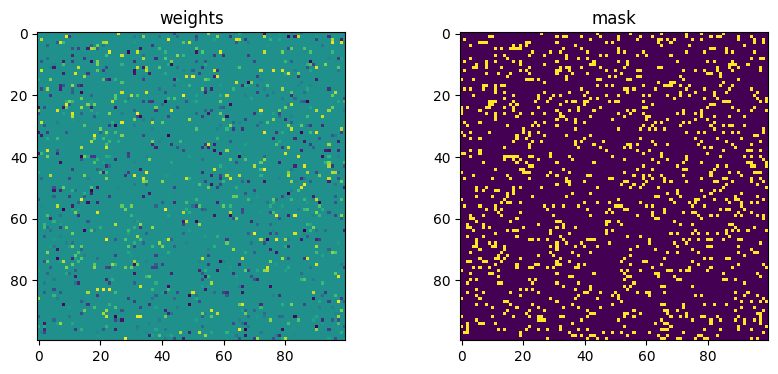

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain.mask)
plt.show()

# Brain predict history

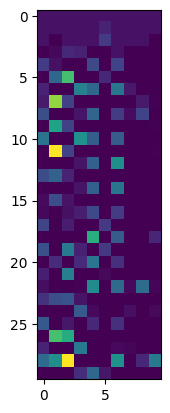

In [8]:
# History of output neuron fire
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=False)); plt.show()

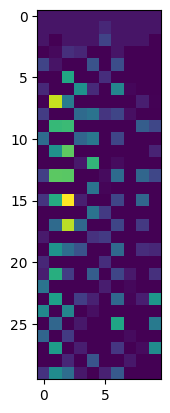

In [9]:
# History of output neuron fire with constant input
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=True)); plt.show()

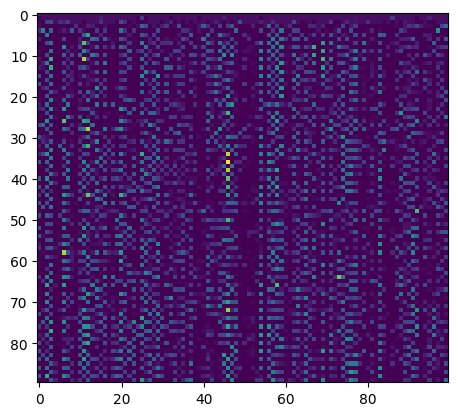

In [10]:
# History of all neurons
brain.initialize_neurons()
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False)); plt.show()

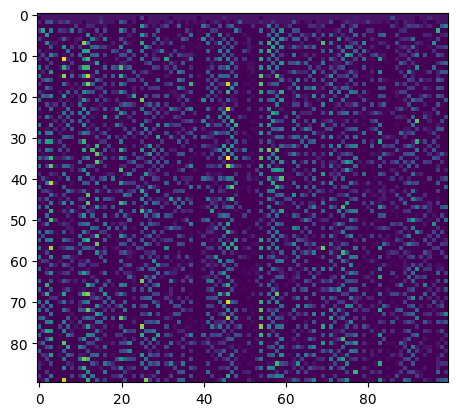

In [11]:
# History of all neurons with constant input
brain.initialize_neurons()
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=True)); plt.show()

# Brain response to different inputs

,0,1,2,3,4,5,6,7,8,9
0,3.935700,-1.000000,-1.000000,0.191845,5.625709,-1.000000,2.623747,-0.308754,3.118194,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,2.078444,-1.000000,-1.000000,1.706902,1.035418,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,-1.000000,0.562623,-1.000000,4.031615,-1.000000,5.121793,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,4.373316,0.429114,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,1.453290,13.543540,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
7,-1.000000,-1.000000,-1.000000,6.500956,10.031946,-1.000000,9.185116,-0.056334,-1.000000,-1.000000
8,0.577396,-1.000000,7.826581,2.022706,-1.000000,-1.000000,2.623747,-1.000000,4.106656,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,-1.000000,-1.000000,-1.000000,11.892109,-1.000000,4.845517,-1.000000,-1.000000,1.169522
1,-0.786987,5.090349,5.083811,-1.000000,-1.000000,-1.000000,0.860608,-0.740018,4.868946,-0.954339
2,-1.000000,-1.000000,-1.000000,2.363464,-1.000000,-1.000000,2.873747,-0.262885,-1.000000,-1.000000
3,4.003958,-1.000000,-1.000000,-1.000000,-1.000000,-0.270985,-1.000000,-0.746955,-1.000000,-1.000000
4,0.833462,-1.000000,3.619152,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,4.663420,7.624045,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
6,-1.000000,12.739342,11.911626,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,-1.000000,7.483760
7,-1.000000,-1.000000,9.918818,-1.000000,2.889665,-1.000000,-1.000000,2.302143,-0.311238,-1.000000
8,1.771033,6.991542,0.715206,-1.000000,-1.000000,0.880032,-1.000000,-1.000000,3.955470,-1.000000
9,-1.000000,-1.000000,2.916369,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,8.371576,-1.000000,4.202605,-0.000403,-1.000000,4.845517,-1.000000,2.520715,3.068185
1,-1.000000,8.586280,8.788831,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,3.151656,-0.412455
2,-0.998865,-1.000000,-1.000000,3.637492,-1.000000,-1.000000,2.623747,1.433222,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,4.229607,2.114115,1.211048,-1.000000,-0.910878,-1.000000,-1.000000
4,-1.000000,-1.000000,8.005880,-1.000000,1.190555,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,0.980623,-1.000000,7.176350,3.389391,-1.000000,-1.000000,3.839598,1.616861,-1.000000,-1.000000
6,-1.000000,2.147129,4.566260,-1.000000,-1.000000,5.768284,1.762585,-1.000000,-1.000000,-1.000000
7,-1.000000,5.808799,-1.000000,-0.493324,7.312177,-1.000000,6.963346,-1.000000,-1.000000,3.150204
8,-1.000000,6.121003,10.175071,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.758936,2.695865
9,2.708582,8.091621,4.338938,-1.000000,8.670223,4.037545,-1.000000,0.266244,-1.000000,-1.000000


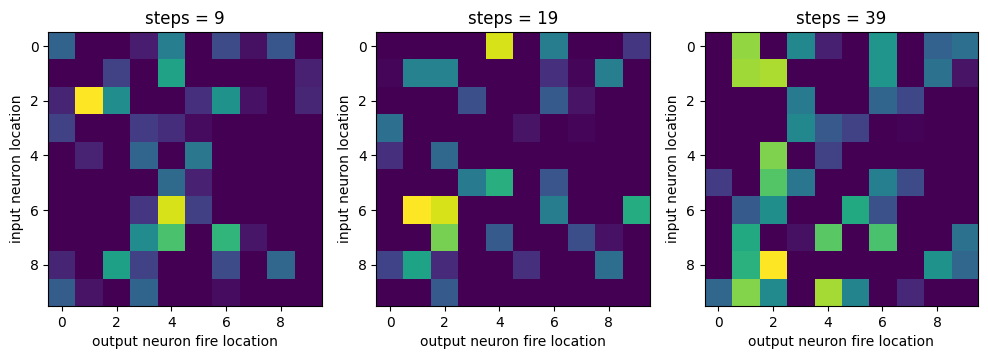

In [12]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=False)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location');
    plt_subplot += 1
plt.show()

,0,1,2,3,4,5,6,7,8,9
0,2.058020,-1.000000,-1.000000,5.004179,5.625709,1.691742,2.623747,-0.308754,-1.000000,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,5.101779,-1.000000,-1.000000,1.706902,1.911442,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,4.733255,-1.000000,-1.000000,3.055309,-1.000000,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,0.883509,-0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,-1.000000,13.543540,1.952846,-1.000000,-1.000000,-1.000000,0.945199
7,-1.000000,-1.000000,-1.000000,11.196885,2.114115,-1.000000,-0.500000,-0.641976,1.843674,-1.000000
8,2.523335,-1.000000,7.714900,-1.000000,-1.000000,-1.000000,2.623747,-1.000000,2.925541,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,0.269984,-1.000000,-1.000000,-1.000000,1.447384,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
1,-0.087843,2.431581,-1.000000,7.461655,-1.000000,-1.000000,9.185116,-1.000000,3.172812,3.421356
2,5.162124,9.531854,5.138148,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000,5.795442
3,3.707237,-1.000000,0.237811,-1.000000,10.531544,-1.000000,-0.954954,-1.000000,-1.000000,-1.000000
4,6.348965,-1.000000,-1.000000,1.366143,10.499024,-1.000000,-1.000000,1.539956,-1.000000,-1.000000
5,2.713793,-1.000000,-1.000000,-1.000000,4.491899,6.420125,-1.000000,3.149476,-1.000000,-0.506804
6,2.038561,-1.000000,6.867652,-1.000000,-1.000000,-1.000000,-1.000000,-0.324393,1.882944,0.964085
7,-1.000000,-1.000000,-1.000000,-1.000000,9.365215,5.082246,-1.000000,-1.000000,-1.000000,-1.000000
8,4.625964,3.028768,-1.000000,-1.000000,-1.000000,3.065786,-1.000000,-1.000000,-1.000000,4.368636
9,-1.000000,2.961785,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,1.709921,8.352116,-1.000000,-1.000000,1.045776,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
1,3.030938,6.307784,3.825541,-1.000000,0.151608,1.095900,4.845517,-1.0,-1.000000,3.833556
2,2.132896,7.418875,12.487556,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.078361,2.695865
3,0.980623,-1.000000,7.075139,3.048633,-1.000000,-1.000000,-0.500000,-1.0,-1.000000,-1.000000
4,-1.000000,4.374673,11.964267,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
5,3.157620,4.375212,-1.000000,-1.000000,-1.000000,-0.850707,-1.000000,-1.0,-1.000000,-1.000000
6,3.132234,6.473301,4.709015,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1.223505,2.695865
7,-1.000000,12.318329,8.942683,-0.455831,-1.000000,-1.000000,1.721770,-1.0,3.151656,1.388610
8,-1.000000,-1.000000,-1.000000,7.867642,-1.000000,-1.000000,2.623747,-1.0,-1.000000,-1.000000
9,0.577396,9.319843,-1.000000,3.861847,4.579530,-1.000000,2.623747,-1.0,-1.000000,-1.000000


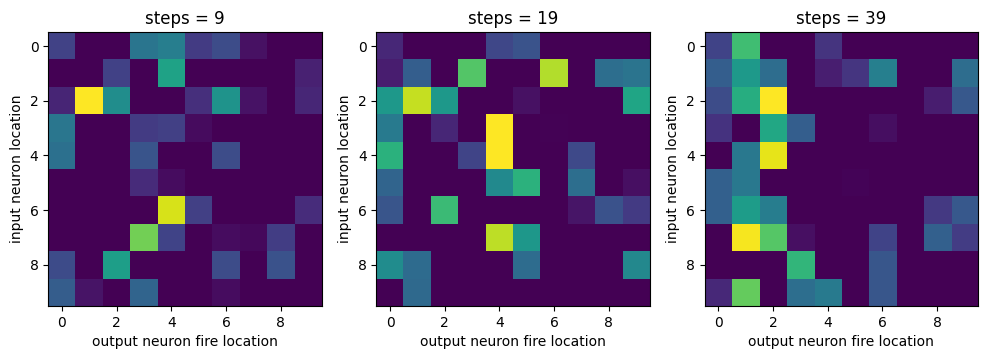

In [13]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=True)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location');
    plt_subplot += 1
plt.show()

# constant inputs and non-constant vs outputs at various timesteps

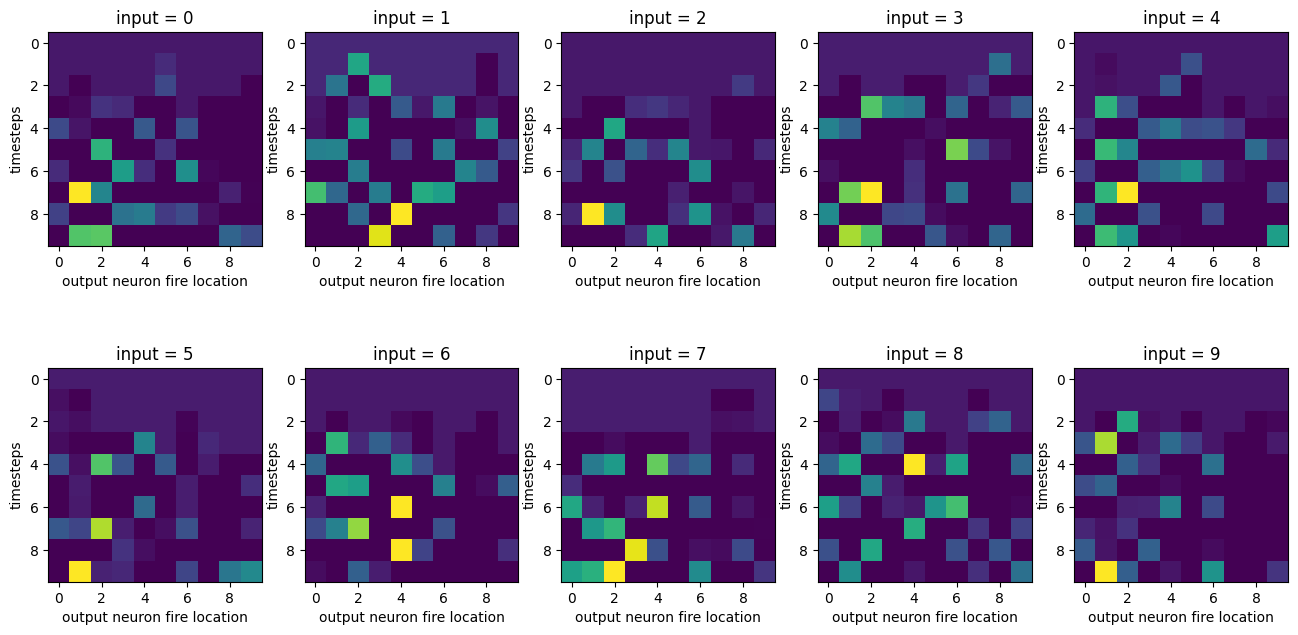

In [15]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=True)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location');
    plt_subplot[2] += 1
plt.show()

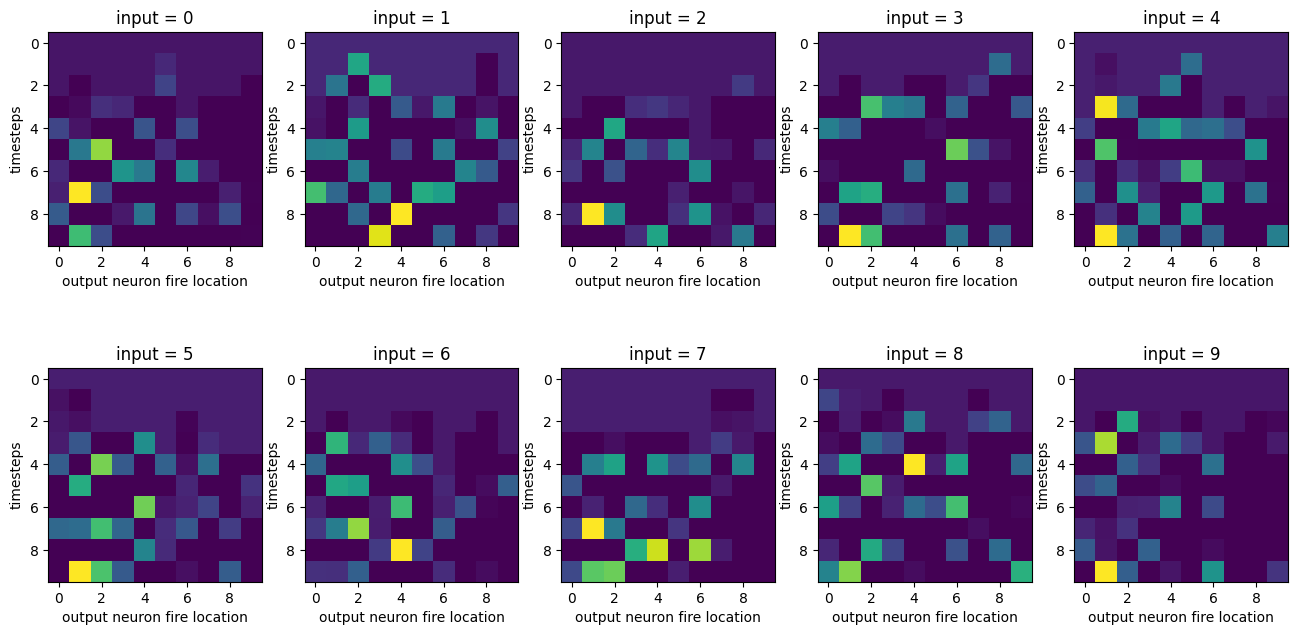

In [16]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=False)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location');
    plt_subplot[2] += 1
plt.show()

# Train with Hebbian like theory

Non-constant input


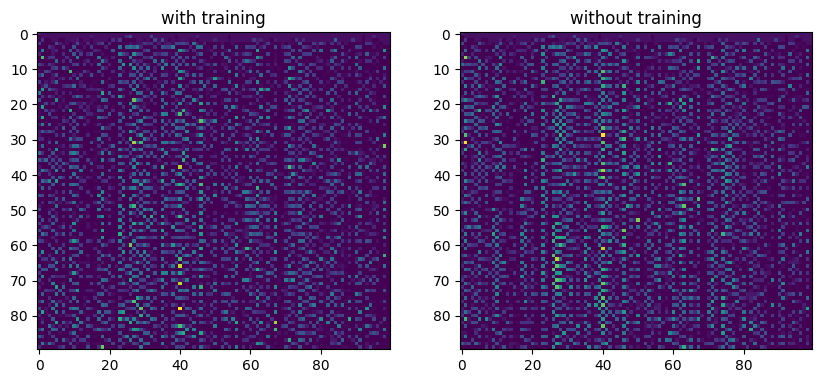

In [17]:
print('Non-constant input')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False))
plt.show()

Constant input


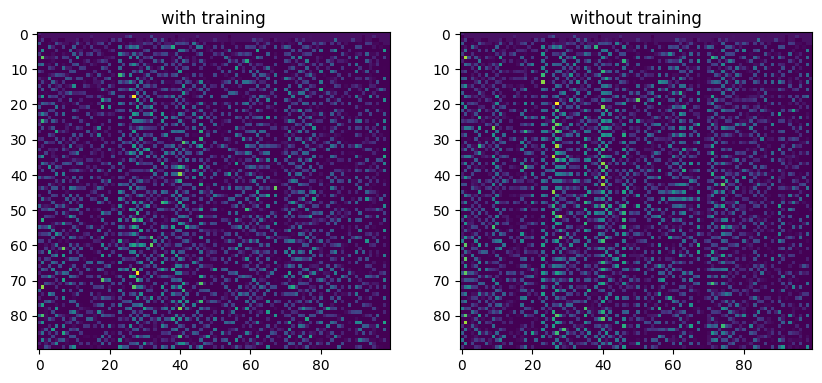

In [18]:
print('Constant input')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=True))
plt.show()

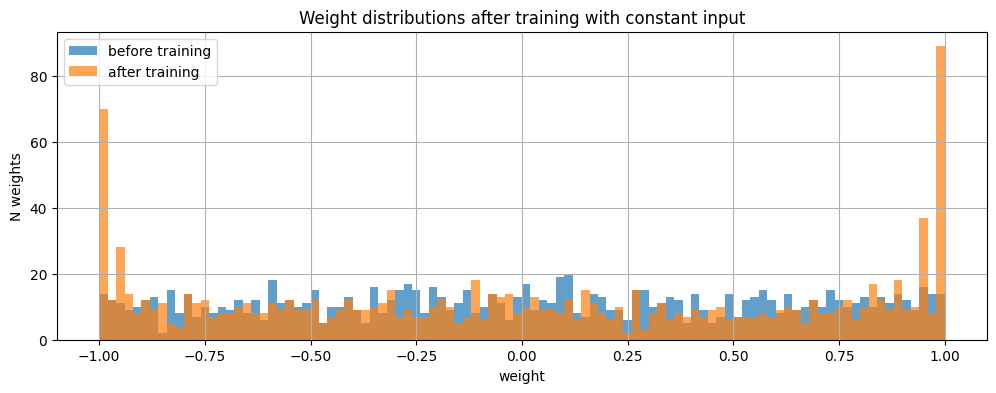

In [19]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

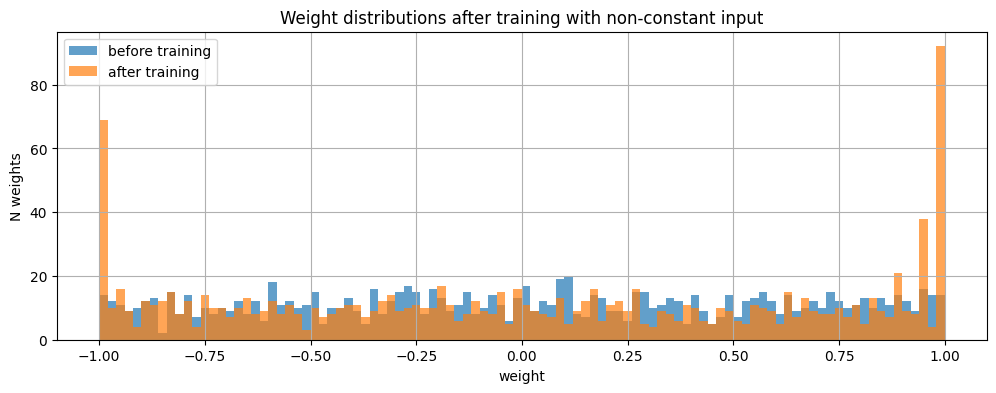

In [20]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

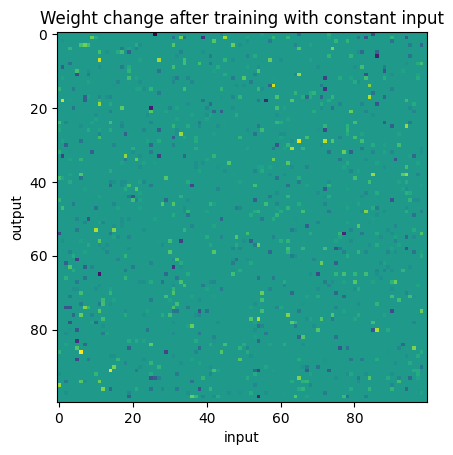

In [21]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()

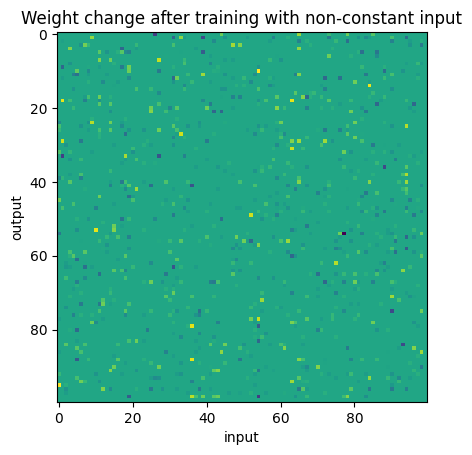

In [22]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()


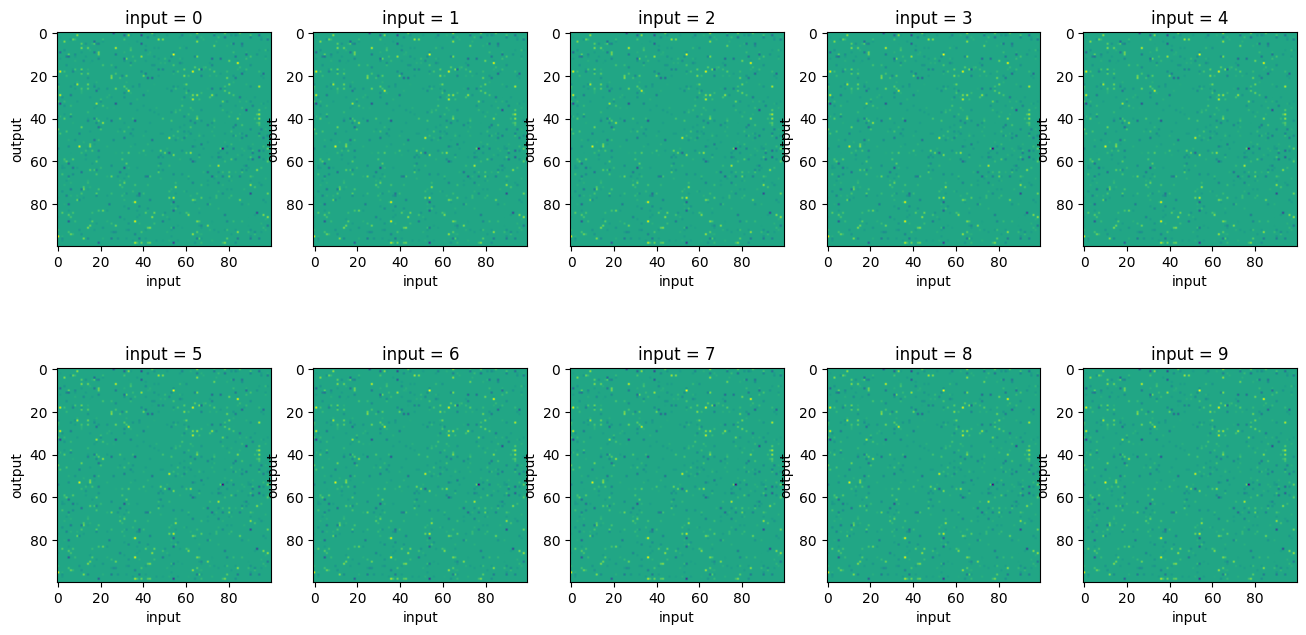

In [23]:
# weight change for various constant inputs
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    brain.initialize_weights(2030)
    W_before = brain.weights
    brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
    dW = brain.weights - W_before
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(dW)
    plt.ylabel('output'); plt.xlabel('input');
    plt_subplot[2] += 1
plt.show()

# On real image

In [26]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

print(x_train.shape, x_test.shape, y_train.shape)
print(x_train.min(), x_train.max())

(60000, 784) (10000, 784) (60000,)
0.0 1.0


# creating and training the SNN

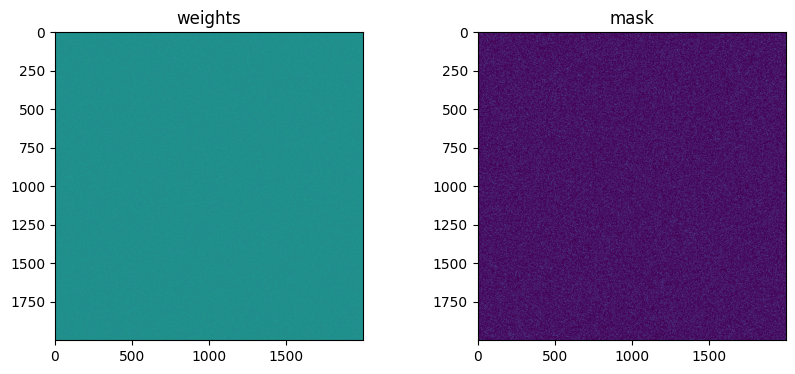

In [27]:
# Create our brain
brain_mnist = Brain(n_neurons=2000, n_inputs=784, n_outputs=10, n_connections=100)

plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain_mnist.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain_mnist.mask)
plt.show()

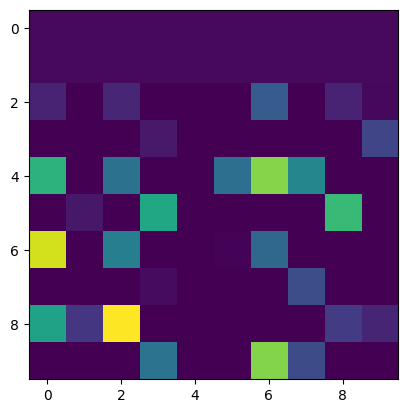

In [28]:
plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

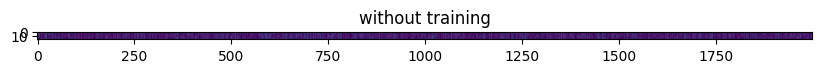

In [29]:
# before training
plt.figure(figsize=(10, 5))
brain_mnist.initialize_neurons()
brain_mnist.initialize_weights(2030)
plt.title('without training')
plt.imshow(brain_mnist.predict_brain_history(x_train[0], 20, constant_input=True))
plt.show()

weights_before = brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)]

In [30]:
%%time
# training
brain_mnist.train_hebbian_brain_batch(x_train, 1000)

training steps: 100 x 10


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 58.8 s, sys: 40 s, total: 1min 38s
Wall time: 1min 5s


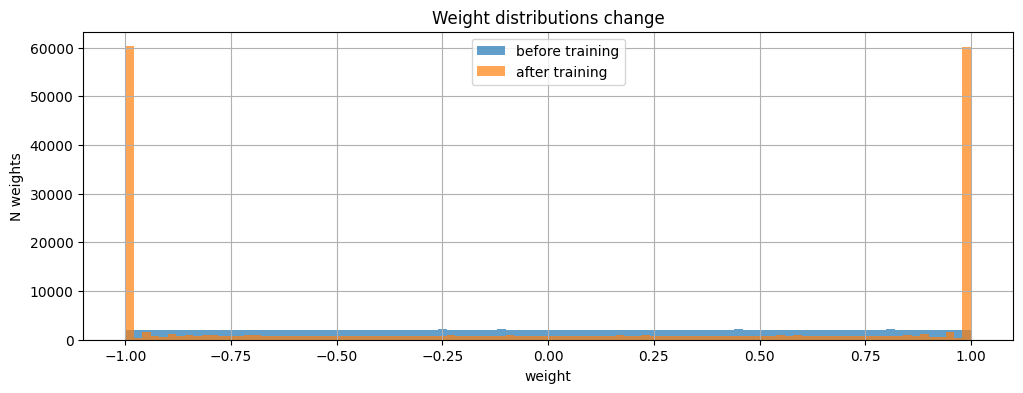

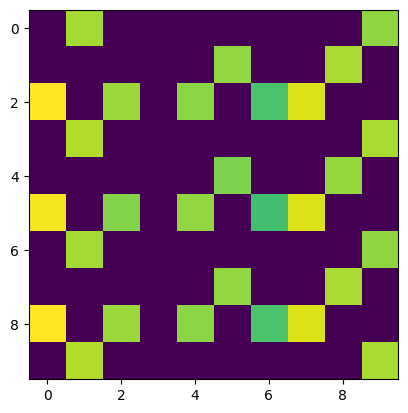

In [32]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions change')
plt.hist(weights_before, bins=plt_bins, label='before training', alpha=0.7)
plt.hist(brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

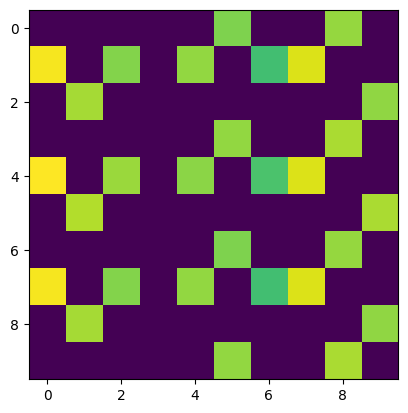

In [33]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=True)); plt.show()

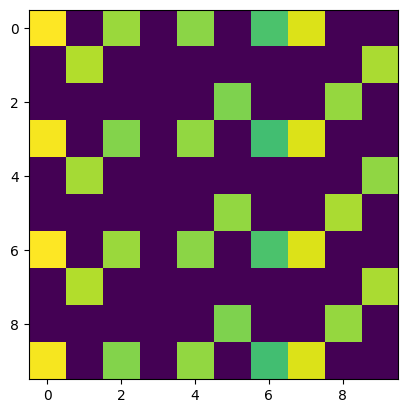

In [34]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=False)); plt.show()

# simple optimization method for training the Spiking Neural Network (SNN)

In [37]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

print(x_train.shape, x_test.shape, y_train.shape)


(60000, 784) (10000, 784) (60000,)


In [46]:
class Brain():
    def __init__(self, n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10,
                 low=-1, resting=0, threshold=1, peak=5, decay=0.5, seed=2020):
        assert n_neurons >= n_outputs + n_inputs
        assert n_neurons >= n_connections
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_connections = n_connections
        self.low = low
        self.resting = resting
        self.threshold = threshold
        self.peak = peak
        self.decay = decay
        np.random.seed(seed)
        self.mask = self.generate_mask()
        self.initialize_weights()
        self.initialize_neurons()

    def generate_mask(self):
        threshold = (self.n_connections + 1) / self.n_neurons
        return (np.random.rand(self.n_neurons, self.n_neurons) < threshold) & ~np.identity(self.n_neurons, dtype='bool')

    def initialize_weights(self, seed=None):
        if seed:
            np.random.seed(seed)
        self.weights = (2 * np.random.rand(self.n_neurons, self.n_neurons).astype('float32') - 1) * self.mask

    def initialize_neurons(self):
        self.neurons = np.ones(self.n_neurons).astype('float32') * self.resting
        self.neurons_fire = np.zeros(self.n_neurons, dtype='bool')

    def forward_pass(self):
        neurons_next = np.dot(self.weights, self.neurons_fire * self.peak) + self.decay * self.neurons
        neurons_next = np.where(self.neurons_fire, self.low, neurons_next)
        neurons_next = np.clip(neurons_next, a_min=self.low, a_max=None)
        self.neurons = neurons_next
        self.neurons_fire = self.neurons >= self.threshold

    def train_hebbian_one_step(self, learning_rate=0.05):
        prev_fire = self.neurons_fire
        self.forward_pass()
        next_fire = self.neurons_fire
        dW = learning_rate * self.mask * (
            next_fire.reshape(-1, 1) * prev_fire ^ prev_fire.reshape(-1, 1) * next_fire
        )
        self.weights = np.clip(self.weights + dW, a_min=-1, a_max=1)


    def set_inputs(self, inputs):
        self.neurons[:self.n_inputs] = inputs / self.decay

    def get_outputs(self):
        return self.neurons[self.n_inputs : self.n_inputs + self.n_outputs]

    def predict(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
        return self.get_outputs()

    def predict_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_outputs), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.get_outputs()
        return hist

    def predict_brain_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.neurons
        return hist

    def train_hebbian_brain_history(self, inputs, steps=10, lr=0.05, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input:
                self.set_inputs(inputs)
            self.train_hebbian_one_step(lr)
            hist[step] = self.neurons
        return hist

    def train_hebbian_brain_batch(self, X, total_steps=1000, steps_per_sample=10, lr=0.05, constant_input=True):
        n_samples_train = np.ceil(total_steps / steps_per_sample).astype('int')
        total_steps = n_samples_train * steps_per_sample
        if n_samples_train > len(X):
            X = np.vstack([X] * np.ceil(n_samples_train / len(X)).astype('int'))
        X = X[:n_samples_train]
        print('training steps:', n_samples_train, 'x', steps_per_sample)
        for x in tqdm(X):
            self.set_inputs(x)
            for _ in range(steps_per_sample):
                if constant_input:
                    self.set_inputs(x)
                self.train_hebbian_one_step(lr)


# Create and train the SNN

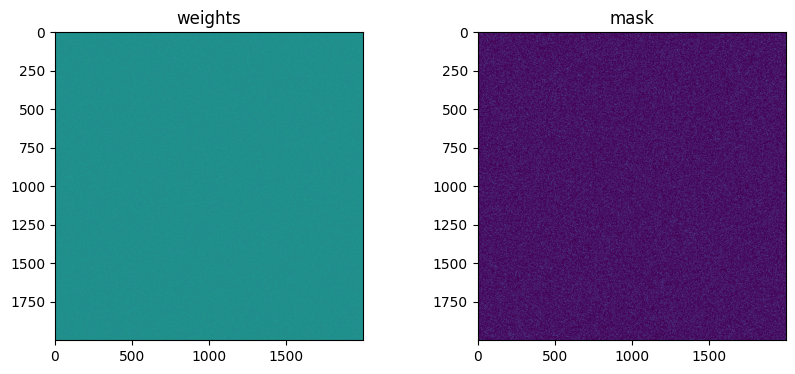

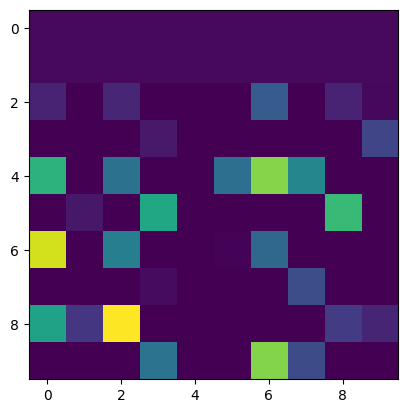

In [47]:
brain_mnist = Brain(n_neurons=2000, n_inputs=784, n_outputs=10, n_connections=100)

plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain_mnist.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain_mnist.mask)
plt.show()

plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()


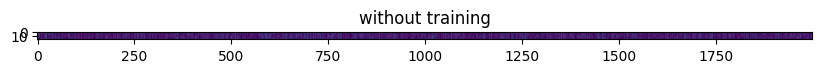

In [48]:

# before training
plt.figure(figsize=(10, 5))
brain_mnist.initialize_neurons()
brain_mnist.initialize_weights(2030)
plt.title('without training')
plt.imshow(brain_mnist.predict_brain_history(x_train[0], 20, constant_input=True))
plt.show()

weights_before = brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)]



training steps: 100 x 10


  0%|          | 0/100 [00:00<?, ?it/s]

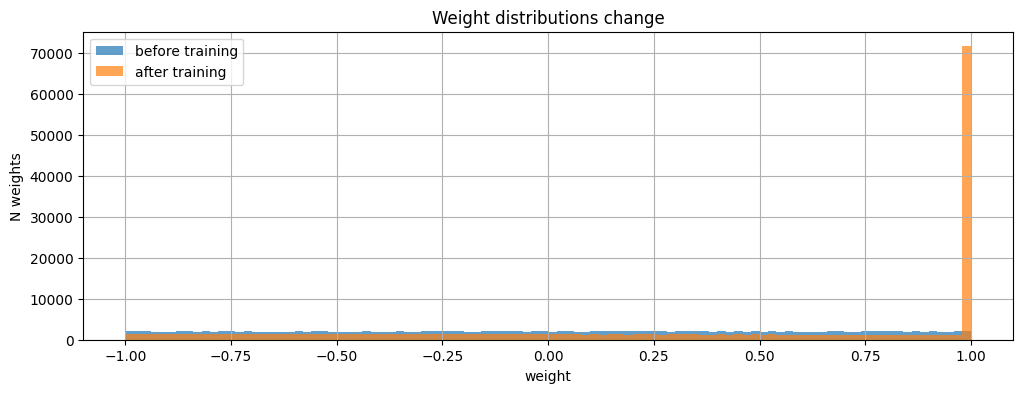

In [50]:
# Training
brain_mnist.train_hebbian_brain_batch(x_train, 1000)

plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions change')
plt.hist(weights_before, bins=plt_bins, label='before training', alpha=0.7)
plt.hist(brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()


The orange histogram shows that the weights have been updated significantly, with a large concentration around 1.
The training process has caused most weights to converge to the maximum value (1), indicating a strong learning or adjustment in the network's synaptic strengths. This could be due to the Hebbian learning rule amplifying the connections based on neuron firing correlations.

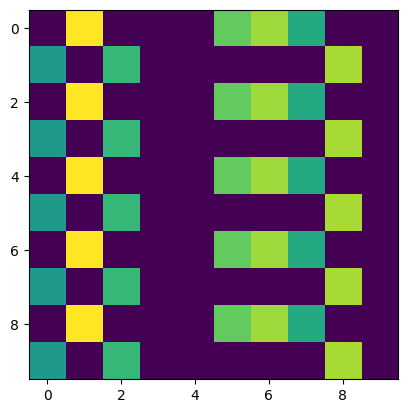

In [51]:
plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

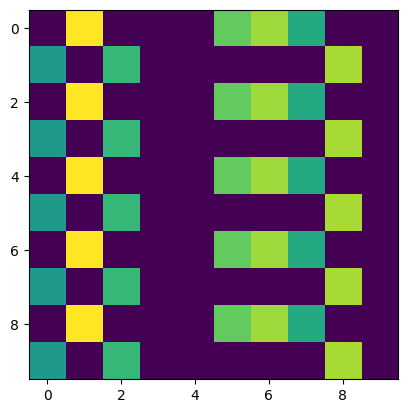

In [52]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=True)); plt.show()

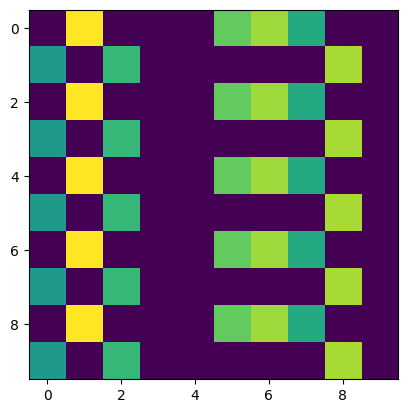

In [53]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=False)); plt.show()